## Deep Neural Network model with top n feature selection
*Summary:* In this notebook, we use a DNN model to predict `attack_cat` labels.

In [88]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [89]:
labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing
The preprocessing includes the reduction of categorical features, one hot encoding the selected categorical features, and clamping the features that have a maximum of 10 times the median to the 95th quantile. 

In [90]:
from preprocessing import apply_clamping, reduce_top_n

x_df = reduce_top_n(x_df, 10)

num_cols = x_df.select_dtypes(include=[np.number]).columns
cat_cols = x_df.select_dtypes(exclude=[np.number]).columns
x_df = pd.concat([x_df[num_cols], pd.get_dummies(x_df[cat_cols])], axis=1)

x_df = apply_clamping(x_df)

As can be seen below, the attack categories are imbalanced

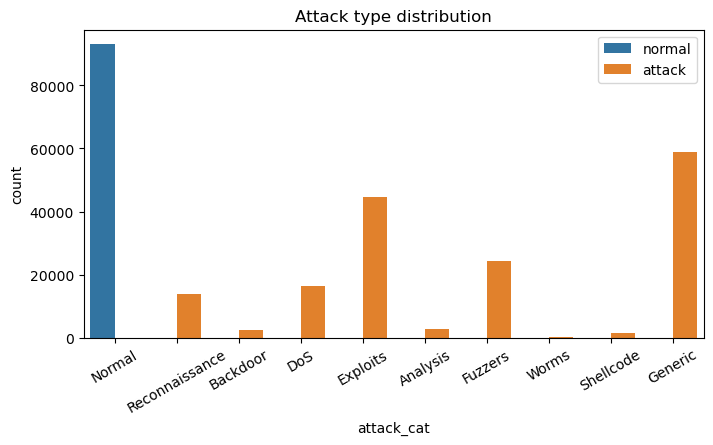

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='attack_cat', hue='label', data=df)
ax.legend(loc="upper right", labels=('normal', 'attack'))
ax.set_title("Attack type distribution")
plt.xticks(rotation=30)
plt.show()

In [92]:
labels.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

We use the SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset 

In [97]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_df, labels)
(X_res.shape, y_res.shape)

((930000, 71), (930000,))

In [98]:
X_res = X_res.iloc[:300000, :]
y_res = y_res.iloc[:300000]

In [99]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_res.iloc[:, :39] = sc.fit_transform(X_res.iloc[:, :39])

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.33, random_state=42)

X_val = X_train.iloc[-10000:]
y_val = y_train.iloc[-10000:]

X_train = X_train.iloc[:-10000]
y_train = y_train.iloc[:-10000]

(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

((191000, 71), (99000, 71), (10000, 71), (191000,), (99000,), (10000,))

In [111]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [112]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(100, activation='relu', input_dim=X_train.shape[1]),
        layers.Dense(100, activation='relu', use_bias=True),
        layers.Dense(100, activation='relu', use_bias=True),
        layers.Dense(100, activation='relu', use_bias=True),
        layers.Dense(100, activation='relu', use_bias=True),
        layers.Dense(10, activation='softmax', use_bias=True)
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               7200      
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 48,610
Trainable params: 48,610
Non-trai

In [113]:
model.compile('adam', loss='categorical_crossentropy', metrics='accuracy')

In [114]:
import os

checkpoint_path = "../models/model_dnn_mc_top10.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [115]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, 
                    batch_size=1000, 
                    shuffle=True, 
                    verbose=2,
                    callbacks=[cp_callback])

Epoch 1/100

Epoch 1: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 - 5s - loss: 0.8071 - accuracy: 0.7056 - val_loss: 0.5866 - val_accuracy: 0.7608 - 5s/epoch - 26ms/step
Epoch 2/100

Epoch 2: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 - 3s - loss: 0.5831 - accuracy: 0.7628 - val_loss: 0.5599 - val_accuracy: 0.7731 - 3s/epoch - 18ms/step
Epoch 3/100

Epoch 3: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 - 4s - loss: 0.5608 - accuracy: 0.7707 - val_loss: 0.5420 - val_accuracy: 0.7723 - 4s/epoch - 21ms/step
Epoch 4/100

Epoch 4: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 - 4s - loss: 0.5458 - accuracy: 0.7771 - val_loss: 0.5320 - val_accuracy: 0.7799 - 4s/epoch - 19ms/step
Epoch 5/100

Epoch 5: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 - 3s - loss: 0.5366 - accuracy: 0.7807 - val_loss: 0.5225 - val_accuracy: 0.7840 - 3s/epoch - 18ms/step
Epoch 6/100

Epoch 6: saving model to ../models\model_dnn_mc_top10.ckpt
191/191 

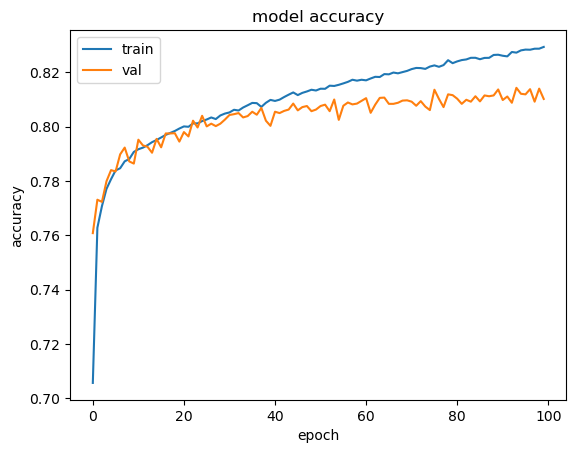

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

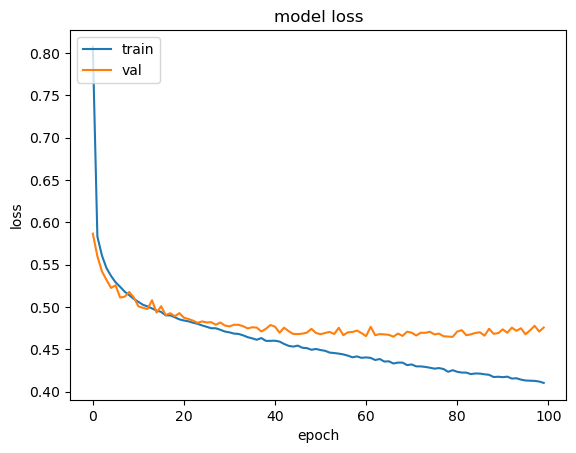

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [118]:
y_pred = model.predict(X_test)

3094/3094 [==============================] - 4s 1ms/step


In [119]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob = self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, sorted(list(labels.unique())))

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

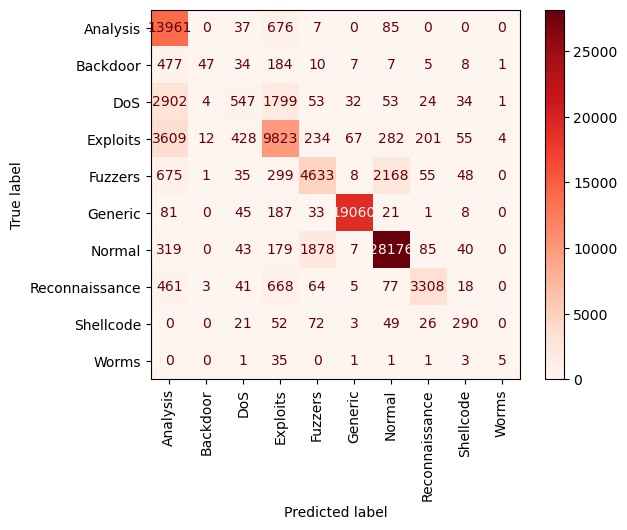

In [121]:
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)